# Раздел 1: Первичный анализ данных (EDA)

In [2]:
#Импорты

#Датасет
from datasets import load_dataset

In [3]:
#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

---

In [4]:
ds = load_dataset("aglazkova/keyphrase_extraction_russian")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['abstract', 'keywords'],
        num_rows: 20844
    })
    test: Dataset({
        features: ['abstract', 'keywords'],
        num_rows: 10004
    })
})


In [5]:
df = ds['train'].to_pandas()
display(df.head())
df.info()

,abstract,keywords
0,В статье рассматривается сущность и диагностик...,"личный состав, вооруженные силы российской фед..."
1,Проведен анализ костюмных комплексов могильник...,"киняминский могильник, накосные украшения, кос..."
2,Вводятся в научный оборот результаты палеокарп...,"черкаскульское население, керамика, палеокарпо..."
3,Статья посвящена одонтологической характеристи...,"одонтология, эпоха бронзы, ямная культура, мор..."
4,В статье рассматривается содержание писем и ра...,"первая мировая война, поволжье, городское насе..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20844 entries, 0 to 20843
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  20844 non-null  object
 1   keywords  20844 non-null  object
dtypes: object(2)
memory usage: 325.8+ KB


Данные преобразованы в pandas DataFrame. Первичный анализ с помощью .info() показывает, что в датасете 20844 записей. Типы данных корректны. Столбцы abstract и keywords полностью заполнены, пропущенные значения отсутствуют."

---

In [6]:
duplicate_count = df.duplicated(subset=['abstract']).sum()
print(f"Обнаружено дублирующихся аннотаций: {duplicate_count}")

Обнаружено дублирующихся аннотаций: 12


Количество дупликатов составляет всего 12 единиц, удалим их

In [7]:
df.drop_duplicates(subset=['abstract'], inplace=True, keep='first')
df.reset_index(drop=True, inplace=True)
print(f"Дубликаты удалены. Новый размер датасета: {len(df)}")

Дубликаты удалены. Новый размер датасета: 20832


---

In [8]:
df['char_length'] = df['abstract'].str.len()
df['word_count'] = df['abstract'].apply(lambda x: len(x.split()))

print("Описательная статистика по длине аннотаций:")
display(df[['char_length', 'word_count']].describe())

Описательная статистика по длине аннотаций:


,char_length,word_count
count,20832.000000,20832.000000
mean,731.433084,85.497456
std,548.198805,66.808406
min,23.000000,2.000000
25%,353.000000,40.000000
50%,544.000000,62.000000
75%,939.000000,109.000000
max,5548.000000,771.000000


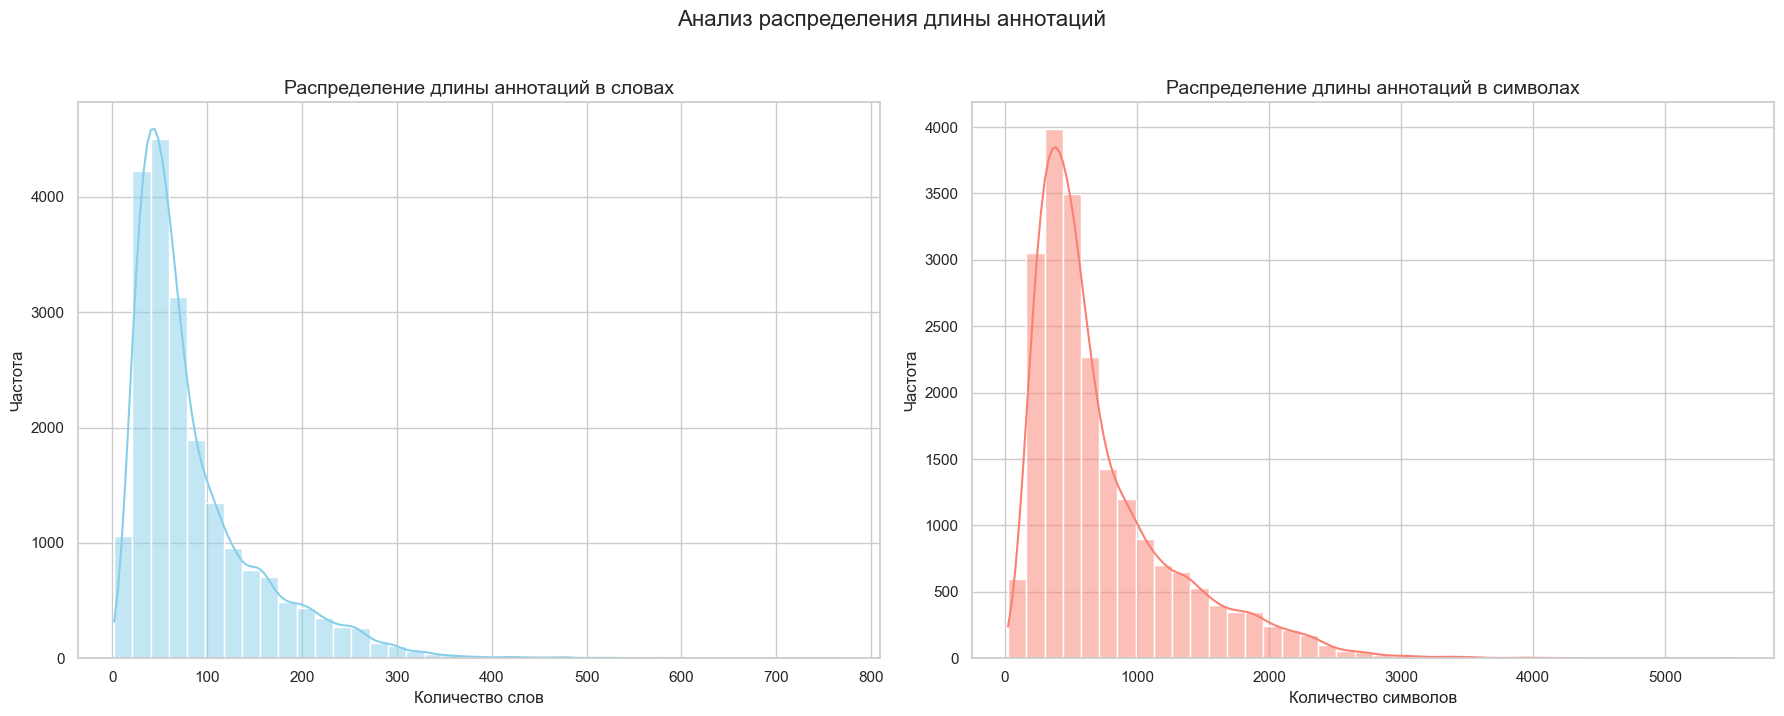

In [9]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(df['word_count'], bins=40, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Распределение длины аннотаций в словах', fontsize=14)
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')

sns.histplot(df['char_length'], bins=40, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Распределение длины аннотаций в символах', fontsize=14)
axes[1].set_xlabel('Количество символов')
axes[1].set_ylabel('Частота')

plt.suptitle('Анализ распределения длины аннотаций', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

* Важные выводы по графикам и статистикам: существуют аномальные аннотауии, требующие дополнительного рассмотрения. В частности существуют аннотации с всего 2 словами, что вероятно является выбросом, рассмотрим другие аннотации где количество слов не превышает 5 ед.

# Раздел 2: Анализ аномалий и очистка данных.

In [10]:
short_abstracts = df[df['word_count'] <= 5]
print(f"Найдено {len(short_abstracts)} аннотаций с 5 или менее словами.")
display(short_abstracts)

Найдено 5 аннотаций с 5 или менее словами.


,abstract,keywords,char_length,word_count
8329,Вработесделанапопыткаразобратьсявособенностяху...,"телевизионная речь, орфоэпия, кодифицированная...",304,3
11646,Рассматривается уравне,"$c$-обобщенная функция, $c$-обобщенное число, ...",23,2
11666,"Доказано, что линейная управляемая систе","линейная управляемая система, равномерная полн...",40,5
11849,Рассматривается линейная нестационарная управл...,линейная управляемая система с периодическими ...,56,5
13012,Предметноориентированные языки (,"предметноориентированный язык, синтаксический ...",32,3


*   "Проведенный анализ выявил несколько классов аномалий в данных, которые критически повлияют на качество моделей:
    1.  **Тексты без пробелов (слипшиеся):** Пример ID 8329. Приводят к полной неработоспособности статистических методов.
    2.  **Оборванные тексты:** Примеры ID 11666, 11849. Содержат неполный контекст, что приведет к нерелевантному извлечению ключевых фраз.
    3.  **Тексты с артефактами парсинга/кодировки:** Пример ID 11646. Зашумляют данные и могут привести к извлечению бессмысленных n-грамм.

Для борьбы с короткими, оборванными и мусорными текстами вводится фильтрация по минимальной длине.
Для обнаружения текстов без пробелов вводится проверка на среднюю длину слова.
После применения этих правил очистки датасет будет перепроверен, а статистики — пересчитаны, чтобы убедиться в чистоте данных перед подачей в модели.

In [11]:
MIN_WORD_COUNT = 25
MAX_AVG_WORD_LEN = 15

In [12]:
def is_valid_abstract(text: str) -> bool:
    """
    Проверяет, является ли аннотация валидной на основе заданных критериев.
    """
    if not isinstance(text, str) or not text.strip():
        return False

    words = text.split()
    word_count = len(words)

    if word_count < MIN_WORD_COUNT:
        return False

    total_chars_in_words = len("".join(words))
        
    avg_word_length = total_chars_in_words / word_count
    
    if avg_word_length > MAX_AVG_WORD_LEN:
        return False

    return True

In [13]:
mask = df['abstract'].apply(is_valid_abstract)
df_cleaned = df[mask].copy()
df_cleaned.reset_index(drop=True, inplace=True)

initial_size = len(df)
final_size = len(df_cleaned)
print(f"Количество аннотаций после фильтрации: {final_size}")
print(f"Количество удаленных аннотаций: {initial_size-final_size}")

Количество аннотаций после фильтрации: 19276
Количество удаленных аннотаций: 1556


In [14]:
df_cleaned['char_length'] = df_cleaned['abstract'].str.len()
df_cleaned['word_count'] = df_cleaned['abstract'].apply(lambda x: len(x.split()))

print("Описательная статистика по длине аннотаций:")
display(df_cleaned[['char_length', 'word_count']].describe())

Описательная статистика по длине аннотаций:


,char_length,word_count
count,19276.000000,19276.000000
mean,776.583524,90.877205
std,545.305481,66.594711
min,132.000000,25.000000
25%,393.000000,45.000000
50%,579.000000,67.000000
75%,989.000000,115.000000
max,5548.000000,771.000000


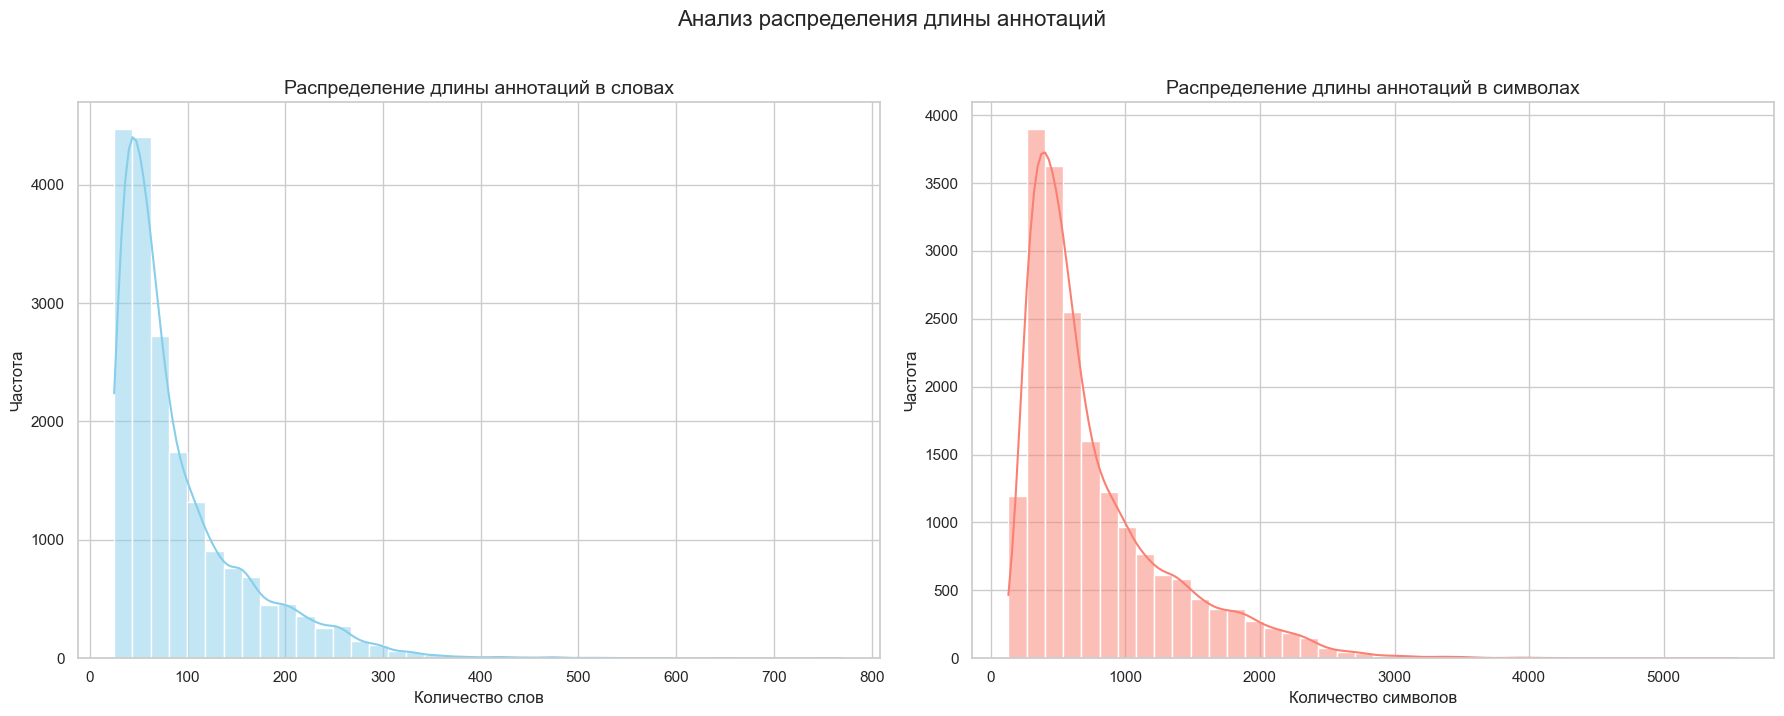

In [15]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.histplot(df_cleaned['word_count'], bins=40, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Распределение длины аннотаций в словах', fontsize=14)
axes[0].set_xlabel('Количество слов')
axes[0].set_ylabel('Частота')

sns.histplot(df_cleaned['char_length'], bins=40, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Распределение длины аннотаций в символах', fontsize=14)
axes[1].set_xlabel('Количество символов')
axes[1].set_ylabel('Частота')

plt.suptitle('Анализ распределения длины аннотаций', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

После манипуляции в статическом обзоре не наблюдаются аномальные аннотации, однако нужно продолжить работу с датасетом для улучшения его качества
После применения фильтров минимальная длина аннотации теперь составляет 25 слов (ранее - 2), что видно из обновленной таблицы describe(). Распределение длин на гистограмме стало более сфокусированным, исчез левый хвост с аномалиями.

# Раздел 3: Анализ целевых ключевых слов (keywords)

Проанализируем предоставленные ключевые слова. Это поможет понять их структуру и происхождение.

In [ ]:
import itertools

In [17]:
def parse_keywords(data):
    if isinstance(data, str):
        return [kw.strip() for kw in data.split(',')]
    return data

In [18]:
df_cleaned['keywords'] = df_cleaned['keywords'].apply(parse_keywords)

Теперь столбец keywords будет иметь удобный формат для работы

In [19]:
df_cleaned['keywords_count'] = df_cleaned['keywords'].apply(len)
df_cleaned['keyword_length_words'] = df_cleaned['keywords'].apply(lambda lst: [len(kw.split()) for kw in lst])

In [20]:
print("Статистика по количеству ключевых фраз на аннотацию:")
display(df_cleaned['keywords_count'].describe())

Статистика по количеству ключевых фраз на аннотацию:


count    19276.000000
mean         4.602044
std          1.666738
min          3.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         21.000000
Name: keywords_count, dtype: float64

/var/folders/rl/0ykyj_7s1wx56ylgms0h9bxh0000gn/T/ipykernel_11291/395399386.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_keyword_lengths, ax=axes[1], palette='viridis')


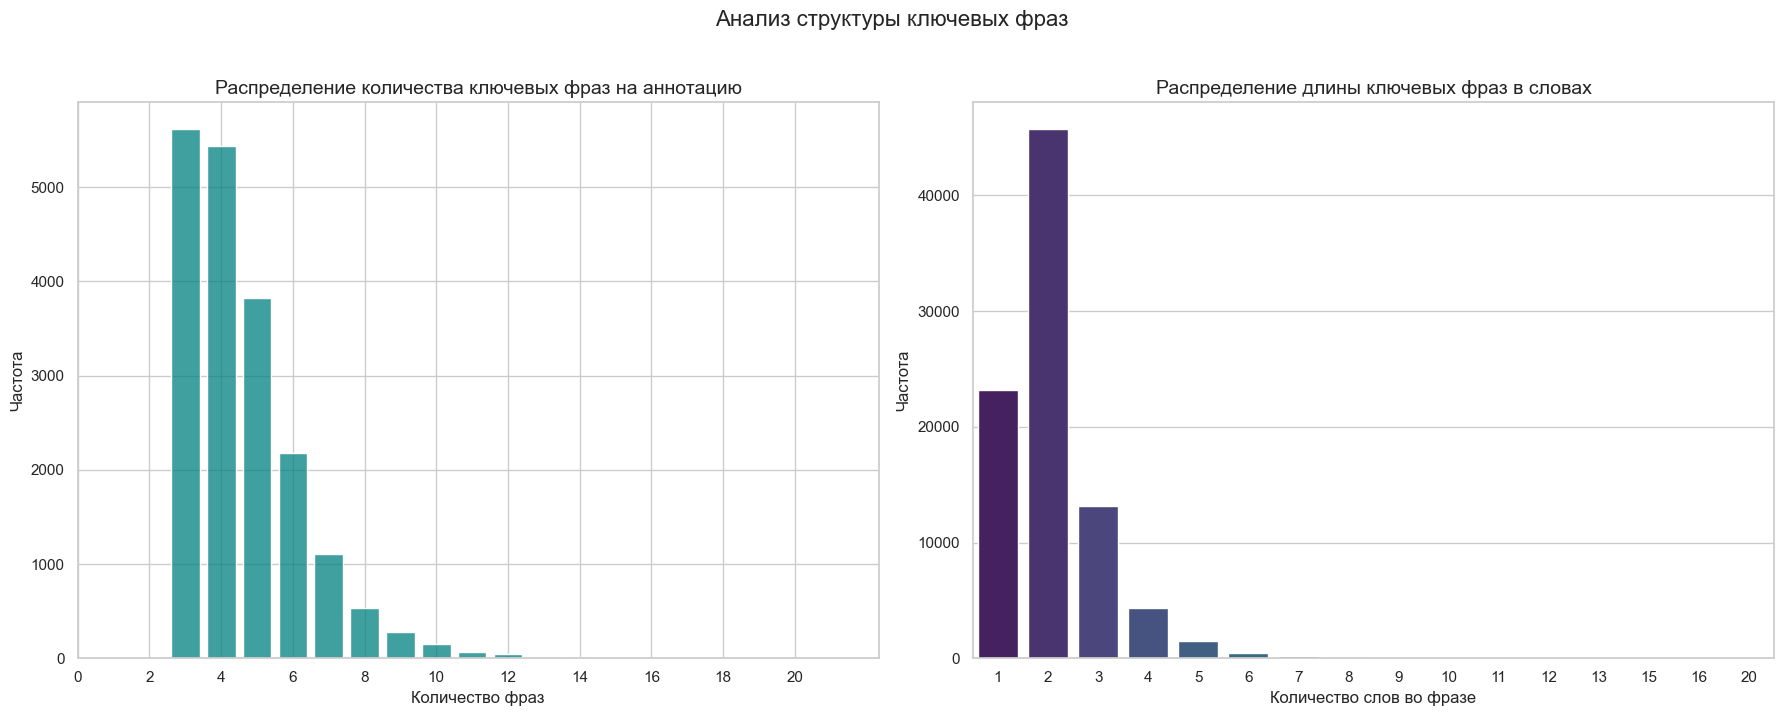

In [21]:
all_keyword_lengths = list(itertools.chain.from_iterable(df_cleaned['keyword_length_words']))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.set_theme(style="whitegrid")

sns.histplot(data=df_cleaned, x='keywords_count', ax=axes[0], discrete=True, shrink=.8, color='teal')
axes[0].set_title('Распределение количества ключевых фраз на аннотацию', fontsize=14)
axes[0].set_xlabel('Количество фраз')
axes[0].set_ylabel('Частота')
axes[0].set_xticks(range(0, df_cleaned['keywords_count'].max() + 1, 2))

sns.countplot(x=all_keyword_lengths, ax=axes[1], palette='viridis')
axes[1].set_title('Распределение длины ключевых фраз в словах', fontsize=14)
axes[1].set_xlabel('Количество слов во фразе')
axes[1].set_ylabel('Частота')

plt.suptitle('Анализ структуры ключевых фраз', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

* В среднем на одну аннотацию приходится около 3-5 ключевых фраз.
*   Подавляющее большинство ключевых фраз состоит из 1, 2 или 3 слов. Это классическая структура для ключевых слов, что подтверждает адекватность данных.

Распределение имеет "хвост" вправо, что говорит о наличии статей с большим количеством ключевых слов (10+), но их доля невелика.
* При настройке наших моделей извлечения мы можем ориентироваться на извлечение примерно 5-7 ключевых фраз из каждого текста. Это будет хорошей эвристикой для большинства случаев.


*  Подавляющее большинство ключевых фраз - это **двухсловные** (биграммы) и **однословные** (униграммы) конструкции. На третьем месте с большим отрывом идут трехсловные фразы (триграммы).
*   **Практическое применение** Это самый важный вывод для построения моделей.
    *   **Для TF-IDF:** Мы должны настроить `TfidfVectorizer` на извлечение n-грамм в диапазоне от 1 до 3 (`ngram_range=(1, 3)`). Искать более длинные n-граммы будет вычислительно затратно и, как показывает график, практически бесполезно.
    *   **Для YAKE:** Алгоритм по своей природе хорошо извлекает многословные конструкции. Данные подтверждают, что применение будет оправдано.
    *   **Для LLM:** При составлении промпта для языковой модели мы можем явно попросить ее "сгенерировать список ключевых фраз, состоящих из 1-3 слов", чтобы ее ответ лучше соответствовал стилю эталонных данных.

# Раздел 4: Предобработка текста для моделей. 

In [ ]:
import re
import nltk
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [ ]:
nltk.download('stopwords')
nltk.download('punkt', quiet=True)

In [24]:
russian_stopwords = stopwords.words("russian")

morph = MorphAnalyzer()
tqdm.pandas()

Для предобработки аннотаций мы произведем следующие манипуляции:
*   Приводим к нижнему регистру для унификации слов.
*   Удаляем пунктуацию, заменяя ее пробелами, но сохраняем кириллические, латинские символы и цифры, так как они несут важную информацию в научных текстах (термины, названия).
*   Проводим лемматизацию для приведения слов к их нормальной форме, что необходимо для корректной работы TF-IDF.
*   Удаляем стоп-слова из стандартного списка NLTK для русского языка, чтобы снизить шум от наиболее частотных, но неинформативных слов.

In [25]:
def preprocess_for_tfidf(text: str, morph_analyzer: MorphAnalyzer, stop_words: list) -> str:
    """
    Полная предобработка текста для TF-IDF:
    - Приведение к нижнему регистру
    - Удаление пунктуации
    - Лемматизация
    - Удаление стоп-слов
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    words = text.split()
    
    lemmatized_words = [morph_analyzer.parse(word)[0].normal_form for word in words]
    
    cleaned_words = [
        word for word in lemmatized_words 
        if word not in stop_words and len(word) > 2
    ]
    
    return " ".join(cleaned_words)

In [26]:
df_cleaned['lemmatized_abstract'] = df_cleaned['abstract'].progress_apply(
    lambda text: preprocess_for_tfidf(text, morph, russian_stopwords)
)

  0%|          | 0/19276 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
display(df_cleaned[['abstract', 'lemmatized_abstract']].head())

,abstract,lemmatized_abstract
0,В статье рассматривается сущность и диагностик...,статья рассматриваться сущность диагностика мо...
1,Вводятся в научный оборот результаты палеокарп...,вводиться научный оборот результат палеокарпол...
2,Статья посвящена одонтологической характеристи...,статья посвятить одонтологический характеристи...
3,В статье рассматривается содержание писем и ра...,статья рассматриваться содержание письмо расск...
4,В статье представлен анализ системы управления...,статья представить анализ система управление м...


In [ ]:
example_idx = 42
print("--- ИСХОДНЫЙ ТЕКСТ (для LLM, эмбеддингов, YAKE) ---")
print(df_cleaned.loc[example_idx, 'abstract'])
print("\n" + "="*50 + "\n")
print("--- ЛЕММАТИЗИРОВАННЫЙ ТЕКСТ (для TF-IDF) ---")
print(df_cleaned.loc[example_idx, 'lemmatized_abstract'])

--- ИСХОДНЫЙ ТЕКСТ (для LLM, эмбеддингов, YAKE) ---
В статье рассматривается военно-политическая деятельность М.В. Фрунзе по вопросам военного строительства Советского государства, идеи и взгляды на реформирование и преобразование Вооруженных Сил, реализованные в трудовой деятельности, а также значение его военно-теоретического наследия для военно-политической теории и практики современной России.


--- ЛЕММАТИЗИРОВАННЫЙ ТЕКСТ (для TF-IDF) ---
статья рассматриваться военный политический деятельность фрунзе вопрос военный строительство советский государство идея взгляд реформирование преобразование вооружённый сила реализовать трудовой деятельность также значение военный теоретический наследие военный политический теория практика современный россия


Мы подготовили данные для всех последующих задач. В датафрейме `df_cleaned` теперь содержатся:

1.  **`abstract`**: Оригинальный, но очищенный от мусора текст. **Будет использоваться для:**
     *   Извлечения ключевых слов с помощью **LLM**.
     *   Извлечения ключевых слов с помощью **YAKE/RAKE**.
     *   Построения **векторных представлений (эмбеддингов)** для семантического поиска.
 
 2.  **`lemmatized_abstract`**: Полностью нормализованный текст. **Будет использоваться для:**
     *   Извлечения ключевых слов с помощью **TF-IDF**.
     *   Построения **векторного пространства TF-IDF** для поиска.
 
 3.  **`keywords`**: Исходные ключевые слова